# Data Importation and Representation

**Authors:**
- Tyrone Lee, Department of Biomedical Informatics, Harvard Medical School (tyrone_lee@hms.harvard.edu)
- Tram Nguyen, Department of Biomedical Informatics, Harvard Medical School (Tram_Nguyen@hms.harvard.edu)
- Pascal Notin, Department of Systems Biology, Harvard Medical School
- Aaron W Kollasch, Department of Systems Biology, Harvard Medical School
- Debora Marks, Department of Systems Biology, Harvard Medical School
- Ludwig Geistlinger, Department of Biomedical Informatics, Harvard Medical School

**Package:** ProteinGymPy

**Date:** November 17, 2025

## Setup

Load the module and all required dependencies used in the vignette.

In [1]:
import proteingympy as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

/home/icarus/projects/ProteinGymPy/.venv/lib/python3.13/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Introduction

Predicting the effects of mutations in proteins is critical to many
applications, from understanding genetic disease to designing novel proteins to
address our most pressing challenges in climate, agriculture and healthcare.
Despite an increase in machine learning-based protein modeling methods,
assessing the effectiveness of these models is problematic due to the use of
distinct, often contrived, experimental datasets and variable performance across
different protein families.

[ProteinGym](https://proteingym.org/) is a large-scale and holistic set of
benchmarks specifically designed for protein fitness prediction and design
curated by @Notin2023.
It encompasses both a broad collection of over 250 standardized deep mutational
scanning (DMS) assays, spanning millions of mutated sequences, as well as
curated clinical datasets providing high-quality expert annotations about
mutation effects. Furthermore, ProteinGym reports the performance of a diverse
set of over 70 high-performing models from various subfields (eg., mutation
effects, inverse folding) into a unified benchmark.

ProteinGym datasets are publicly available as a community resource both on
[Zenodo](https://doi.org/10.5281/zenodo.13932632) and the official [ProteinGym
website](https://proteingym.org/) under the MIT license.

### Available datasets

The `ProteinGymPy` package provides the following analysis-ready datasets from
ProteinGym:

1.  DMS assay scores from 217 assays measuring the impact of all possible amino
    acid substitutions across 186 proteins. The dataset can be obtained using
    the `get_dms_substitution_data()` function

2.  AlphaMissense pathogenicity scores for \~1.6 M substitutions in the
    ProteinGym DMS data. The data is provided with `get_alphamissense_proteingym_data()`.

3.  Reference file containing metadata associated with the 217 DMS assays, such
    as taxon, protein sequence length, UniProt ID, etc. with `get_dms_metadata()`.

4.  Five model performance metrics ("AUC", "MCC", "NDCG", "Spearman",
    "Top_recall") for 79 models across 217 assays calculated on DMS
    substitutions in a zero-shot setting. The data can be obtained with
    `get_zero_shot_metrics()`.

5.  Model scores on the DMS substitutions for 79 models in the zero-shot
    setting. Load with `get_zero_shot_substitution_data()`.

6.  Two model performance metrics ("Spearman", and "MSE") for 12 models across
    217 assays calculated on DMS substitutions in a semi-supervised setting. Load in this data with `get_supervised_metrics()`.

7.  Model scores on the DMS substitutions for 12 semi-supervised models with 3
    folding schemes: contiguous, modulo, and random. Loaded in with
    `get_supervised_substitution_data()` and by changing the "fold_scheme" argument,
    respectively.

8.  PDB files for 197 protein structures, to be used in the `plot_structure()`
    3D visualization function.



## Data import

[ProteinGym data on Zenodo](https://zenodo.org/records/15293562) can be obtained through ProteinGymPy via the API.

### DMS data

Deep mutational scanning is an experimental technique that provides
experimental data on the fitness effects of all possible single mutations in
a protein (Fowler et al. 2024).

For each position in a protein, the amino acid residue is mutated and the
fitness effects are recorded. While most mutations tend to be deleterious, some
can enhance protein activity. In addition to analyzing single mutations, this
method can also examine the effects of multiple mutations, yielding insights
into protein structure and function. Overall, DMS scores provide a detailed map
of how changes in a protein's sequence affect its function, offering valuable

Datasets in `ProteinGymPy` can be easily loaded with built-in functions.

In [2]:
# Load the DICTIONARY of DMS scores for 217 assays
dms_data = pg.get_dms_substitution_data()
print(type(dms_data)) # equivalent to R list
print(dms_data.keys()) # keys are the assay names -> elements names of the R list
print(len(dms_data)) # 217 DMS assays

Using cached file at .cache/DMS_ProteinGym_substitutions.zip.
Querying UniProt API for 185 entries...
<class 'dict'>
dict_keys(['SDA_BACSU_Tsuboyama_2023_1PV0', 'PAI1_HUMAN_Huttinger_2021', 'S22A1_HUMAN_Yee_2023_activity', 'HIS7_YEAST_Pokusaeva_2019', 'AMIE_PSEAE_Wrenbeck_2017', 'ACE2_HUMAN_Chan_2020', 'RDRP_I33A0_Li_2023', 'CASP3_HUMAN_Roychowdhury_2020', 'RL40A_YEAST_Roscoe_2014', 'SRC_HUMAN_Chakraborty_2023_binding-DAS_25uM', 'TRPC_SACS2_Chan_2017', 'GLPA_HUMAN_Elazar_2016', 'BLAT_ECOLX_Jacquier_2013', 'LYAM1_HUMAN_Elazar_2016', 'PABP_YEAST_Melamed_2013', 'Q2N0S5_9HIV1_Haddox_2018', 'DOCK1_MOUSE_Tsuboyama_2023_2M0Y', 'SCN5A_HUMAN_Glazer_2019', 'MYO3_YEAST_Tsuboyama_2023_2BTT', 'CBPA2_HUMAN_Tsuboyama_2023_1O6X', 'RAD_ANTMA_Tsuboyama_2023_2CJJ', 'A4D664_9INFA_Soh_2019', 'CATR_CHLRE_Tsuboyama_2023_2AMI', 'SERC_HUMAN_Xie_2023', 'SRBS1_HUMAN_Tsuboyama_2023_2O2W', 'PPARG_HUMAN_Majithia_2016', 'AICDA_HUMAN_Gajula_2014_3cycles', 'AACC1_PSEAI_Dandage_2018', 'A4_HUMAN_Seuma_2022', 'RS15_GEOSE

View an example of one DMS assay.

In [3]:

# Grab the first assay
first_key = list(dms_data.keys())[0]
print(type(dms_data[first_key])) # Now we see this is a PANDAS DataFrame
print(dms_data[first_key].head()) # Display the first few rows of the DataFrame


<class 'pandas.core.frame.DataFrame'>
  UniProt_id                         DMS_id mutant  \
0     Q7WY62  SDA_BACSU_Tsuboyama_2023_1PV0   A16C   
1     Q7WY62  SDA_BACSU_Tsuboyama_2023_1PV0   A16D   
2     Q7WY62  SDA_BACSU_Tsuboyama_2023_1PV0   A16E   
3     Q7WY62  SDA_BACSU_Tsuboyama_2023_1PV0   A16F   
4     Q7WY62  SDA_BACSU_Tsuboyama_2023_1PV0   A16G   

                               mutated_sequence  DMS_score DMS_score_bin  
0  MRKLSDELLIESYFKCTEMNLNRDFIELIENEIKRRSLGHIISV  -0.533935             1  
1  MRKLSDELLIESYFKDTEMNLNRDFIELIENEIKRRSLGHIISV  -2.151397             0  
2  MRKLSDELLIESYFKETEMNLNRDFIELIENEIKRRSLGHIISV  -0.870078             1  
3  MRKLSDELLIESYFKFTEMNLNRDFIELIENEIKRRSLGHIISV  -0.328954             1  
4  MRKLSDELLIESYFKGTEMNLNRDFIELIENEIKRRSLGHIISV  -0.961885             1  


For each DMS assay, the columns show the UniProt protein identifier, the DMS
experiment assay identifier, the amino acid substitution at a given sequence 
position, the mutated protein sequence, the recorded DMS score, and a binary 
DMS score bin categorizing whether the mutation has an effect on fitness 
(1) or not (0). For details, see the `get_dms_substitution_data` documentation or reference 
publication from Notin et al. 2023.


In [4]:
help(pg.get_dms_substitution_data)

Help on function get_dms_substitution_data in module proteingympy.make_dms_substitutions:

get_dms_substitution_data(cache_dir: str = '.cache', use_cache: bool = True) -> Dict[str, pandas.core.frame.DataFrame]
    Download and process ProteinGym DMS substitution data.

    Returns a dictionary of 217 DMS assays, each as a pandas DataFrame with columns:
    - UniProt_id: UniProt accession identifier
    - DMS_id: DMS assay identifier
    - mutant: substitution description (e.g. A1P:D2N)
    - mutated_sequence: full amino acid sequence
    - DMS_score: experimental measurement (higher = more fit)
    - DMS_score_bin: binary fitness (1=fit, 0=not fit)

    Args:
        cache_dir: Directory to cache downloaded files
        use_cache: If True, use cached file if it exists. If False, force a fresh download.

    Returns:
        Dictionary mapping DMS study names to DataFrames



## Model benchmarking

The function `pg.benchmark_models()` can be used to compare
performance across several variant effect prediction models when using the 
DMS data as ground truth. This function takes in one of the five
available metrics, and and compares the performance of up to 5 out of the 
79 available models.

In the zero-shot setting, the effects of mutations on fitness are predicted 
without relying on ground-truth labels for the protein of interest. 
Robust zero-shot performance is particularly informative when labels are
subject to several biases or scarcely available (e.g., labels for rare genetic
pathologies).

Model performance was evaluated across 5 metrics:

1.  Spearman's rank correlation coefficient (default metric)
2.  Area Under the ROC Curve (AUC)
3.  Matthews Correlation Coefficient (MCC), most suitable for bimodal DMS 
measurements
4.  Normalized Discounted Cumulative Gains (NDCG)
5.  Top K Recall (top 10% of DMS values)

To account for the fact that certain protein functions are overrepresented 
in the list of proteins assayed with DMS (e.g., thermostability), these metrics 
were first calculated within groups of proteins with similar functions. The 
final value of the metric is then the average of these averages, giving each 
functional group equal weight. The final values are referred to as the 
'corrected average'.

Due to the often non-linear relationship between protein function and organism
fitness, the Spearman’s rank correlation coefficient is typically an appropriate choice for 
evaluating model performance against experimental measurements. However, in 
situations where DMS measurements exhibit a bimodal profile, rank correlations 
may not be the optimal choice. Therefore, additional metrics are also provided, 
such as the Area Under the ROC Curve (AUC) and the Matthews Correlation 
Coefficient (MCC), which compare binarized model scores and experimental 
measurements. Furthermore, for certain goals (e.g., optimizing functional 
properties of designed proteins), it is more important that a model is able to 
correctly identify the most functional protein variants, rather than properly 
capture the overall distribution of all assayed variants. For such scenarios, 
it is beneficial to use the Normalized Discounted Cumulative Gains (NDCG) which 
prioritizes models that return high scores for sequences with high DMS value 
(corresponding to strong gain in fitness). Alternatively, the Top K Recall 
(with K being set to the top 10% of DMS values) can also be informative for such 
scenarios.

To view all available zero-shot models, use the function: `pg.available_models()`.

In [5]:
zmodels = pg.available_models()
print(zmodels)

['Site_Independent', 'EVmutation', 'DeepSequence_single', 'DeepSequence_ensemble', 'EVE_single', 'EVE_ensemble', 'Unirep', 'Unirep_evotune', 'MSA_Transformer_single', 'MSA_Transformer_ensemble', 'ESM1b', 'ESM1v_single', 'ESM1v_ensemble', 'ESM2_8M', 'ESM2_35M', 'ESM2_150M', 'ESM2_650M', 'ESM2_3B', 'ESM2_15B', 'Wavenet', 'RITA_s', 'RITA_m', 'RITA_l', 'RITA_xl', 'Progen2_small', 'Progen2_medium', 'Progen2_base', 'Progen2_large', 'Progen2_xlarge', 'GEMME', 'VESPA', 'VESPAl', 'VespaG', 'ProtGPT2', 'Tranception_S_no_retrieval', 'Tranception_M_no_retrieval', 'Tranception_L_no_retrieval', 'Tranception_S', 'Tranception_M', 'Tranception_L', 'TranceptEVE_S', 'TranceptEVE_M', 'TranceptEVE_L', 'CARP_38M', 'CARP_600K', 'CARP_640M', 'CARP_76M', 'MIF', 'MIFST', 'ESM_IF1', 'ProteinMPNN', 'ProtSSN_k10_h512', 'ProtSSN_k10_h768', 'ProtSSN_k10_h1280', 'ProtSSN_k20_h512', 'ProtSSN_k20_h768', 'ProtSSN_k20_h1280', 'ProtSSN_k30_h512', 'ProtSSN_k30_h768', 'ProtSSN_k30_h1280', 'ProtSSN_ensemble', 'SaProt_650M_AF

Now, plot the AUC metric for 5 models.

Download complete.
Loading AUC scores...
Loading MCC scores...
Loading NDCG scores...
Loading Spearman scores...
Loading Top_recall scores...
Benchmark data consistency verified.


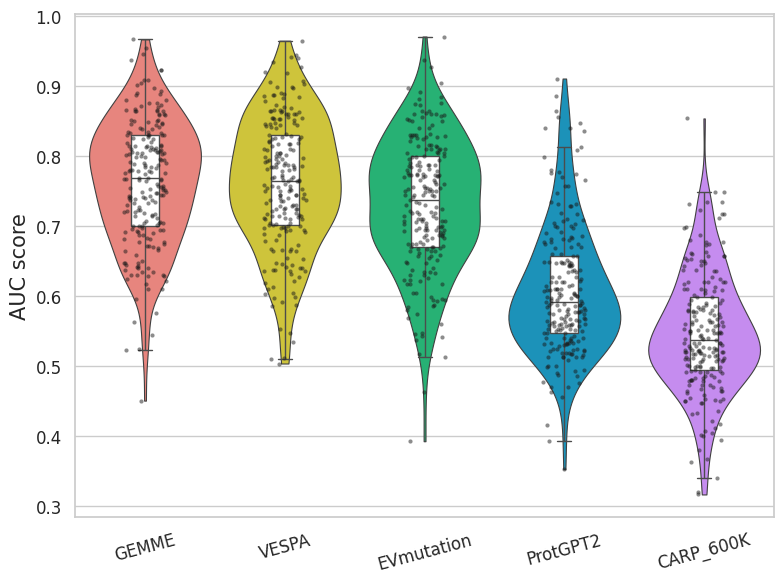

In [6]:
fig = pg.benchmark_models(metric = "AUC", 
    models = ["GEMME", "CARP_600K", "EVmutation", "VESPA", "ProtGPT2"])
plt.show()

Here, GEMME performed the best, achieving highest AUC of the 5 selected models. 
If not specified by the user, Spearman correlation is used as the default 
metric. For more information about the models and metrics, see the
function documentation for `benchmark_models()`.


## References

- Notin, P., et al. (2023). ProteinGym: Large-Scale Benchmarks for Protein Design and Fitness Prediction. *Advances in Neural Information Processing Systems*, 36.
- Fowler, D. M. and Fields, S. (2014). Deep mutational scanning: a new style of protein science. *Nature Methods*, 11, 801--807.
- Chan, K. K., et al. (2020). Engineering human ACE2 to optimize binding to the spike protein of SARS coronavirus 2. *Science*, 369(6508), 1261-1265.
- Lee, J. M., et al. (2018). Deep mutational scanning of hemagglutinin helps predict evolutionary fates of human H3N2 influenza variants. *Proceedings of the National Academy of Sciences*, 115(35), E8276-E8285.

